In [1]:
from keras.optimizers import Adam
from keras.layers import Dense, Input, concatenate
from keras.models import Model
import matplotlib.pyplot as plt

from tensorflow.keras.regularizers import l2
from tensorflow.keras.regularizers import l1
from tensorflow.keras.layers import Dropout

import pandas as pd
import os
import re
import pandas as pd

In [2]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import KFold
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, auc

In [3]:
import random
import tensorflow as tf
import numpy as np

#Set global seeds
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

## Model

In [4]:
'''
Script: resnet_builder_keras.py
Dependency environment: tf_gpu

Script for building 3D Resnet models in pure Keras. 
Code adapted from https://github.com/JihongJu/keras-resnet3d updated for TF2.0
'''

from __future__ import (
    absolute_import,
    division,
    print_function,
    unicode_literals
)
import six
from math import ceil
import keras
from keras.models import Model
from keras.layers import (
    Input,
    Activation,
    Dense,
    Flatten,
    Add
)

from keras.layers import (
    Conv3D,
    AveragePooling3D,
    MaxPooling3D,
    Dropout
)

from keras.layers import concatenate
from keras.layers import BatchNormalization
from keras.regularizers import l2
from keras import backend as K


def _bn_relu(input):
    """Helper to build a BN (non-trainable) -> relu block."""
    norm = BatchNormalization(axis=CHANNEL_AXIS, trainable=False)(input)  # Set trainable to False
    return Activation("relu")(norm)

def _conv_bn_relu3D(**conv_params):
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1, 1))
    kernel_initializer = conv_params.setdefault(
        "kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer",
                                                l2(1e-4))

    def f(input):
        conv = Conv3D(filters=filters, kernel_size=kernel_size,
                      strides=strides, kernel_initializer=kernel_initializer,
                      padding=padding,
                      kernel_regularizer=kernel_regularizer)(input)
        return _bn_relu(conv)

    return f

def _bn_relu_conv3d(**conv_params):
    """Helper to build a BN -> relu -> Dropout -> conv3d block."""
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1, 1))
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1e-4))
    dropout_rate = conv_params.setdefault("dropout_rate", 0.1)  # Set the dropout rate here

    def f(input):
        activation = _bn_relu(input)
        dropout = Dropout(rate=dropout_rate)(activation)  # Apply dropout after activation
        conv = Conv3D(
            filters=filters,
            kernel_size=kernel_size,
            strides=strides,
            kernel_initializer=kernel_initializer,
            padding=padding,
            kernel_regularizer=kernel_regularizer
        )(dropout)
        return conv
    
    return f


def _shortcut3d(input, residual):
    """3D shortcut to match input and residual and merges them with "sum"."""
    stride_dim1 = ceil(int(input.shape[DIM1_AXIS]) \
        / float(int(residual.shape[DIM1_AXIS])))
    stride_dim2 = ceil(int(input.shape[DIM2_AXIS]) \
        / float(int(residual.shape[DIM2_AXIS])))
    stride_dim3 = ceil(int(input.shape[DIM3_AXIS]) \
        / float(int(residual.shape[DIM3_AXIS])))
    equal_channels = residual.shape[CHANNEL_AXIS] \
        == input.shape[CHANNEL_AXIS]

    shortcut = input
    if stride_dim1 > 1 or stride_dim2 > 1 or stride_dim3 > 1 \
            or not equal_channels:
        shortcut = Conv3D(
            filters=residual.shape[CHANNEL_AXIS],
            kernel_size=(1, 1, 1),
            strides=(stride_dim1, stride_dim2, stride_dim3),
            kernel_initializer="he_normal", padding="valid",
            kernel_regularizer=l2(1e-4)
            )(input)
    return Add()([shortcut, residual])


def _residual_block3d(block_function, filters, kernel_regularizer, repetitions,
                      is_first_layer=False):
    def f(input):
        for i in range(repetitions):
            strides = (1, 1, 1)
            if i == 0 and not is_first_layer:
                strides = (2, 2, 2)
            input = block_function(filters=filters, strides=strides,
                                   kernel_regularizer=kernel_regularizer,
                                   is_first_block_of_first_layer=(
                                       is_first_layer and i == 0)
                                   )(input)
        return input

    return f


def basic_block(filters, strides=(1, 1, 1), kernel_regularizer=l2(1e-4),
                is_first_block_of_first_layer=False):
    """Basic 3 X 3 X 3 convolution blocks. Extended from raghakot's 2D impl."""
    def f(input):
        if is_first_block_of_first_layer:
            # don't repeat bn->relu since we just did bn->relu->maxpool
            conv1 = Conv3D(filters=filters, kernel_size=(3, 3, 3),
                           strides=strides, padding="same",
                           kernel_initializer="he_normal",
                           kernel_regularizer=kernel_regularizer
                           )(input)
        else:
            conv1 = _bn_relu_conv3d(filters=filters,
                                    kernel_size=(3, 3, 3),
                                    strides=strides,
                                    kernel_regularizer=kernel_regularizer
                                    )(input)

        residual = _bn_relu_conv3d(filters=filters, kernel_size=(3, 3, 3),
                                   kernel_regularizer=kernel_regularizer
                                   )(conv1)
        return _shortcut3d(input, residual)

    return f


def _handle_data_format():
    global DIM1_AXIS
    global DIM2_AXIS
    global DIM3_AXIS
    global CHANNEL_AXIS
    if K.image_data_format() == 'channels_last':
        DIM1_AXIS = 1
        DIM2_AXIS = 2
        DIM3_AXIS = 3
        CHANNEL_AXIS = 4
    else:
        CHANNEL_AXIS = 1
        DIM1_AXIS = 2
        DIM2_AXIS = 3
        DIM3_AXIS = 4


def _get_block(identifier):
    if isinstance(identifier, six.string_types):
        res = globals().get(identifier)
        if not res:
            raise ValueError('Invalid {}'.format(identifier))
        return res
    return identifier


class Resnet3DBuilder(object):
    """ResNet3D."""

    @staticmethod
    def build(input_shape, num_outputs, block_fn, repetitions, reg_factor):
        """Instantiate a vanilla ResNet3D keras model.
        # Arguments
            input_shape: Tuple of input shape in the format
            (conv_dim1, conv_dim2, conv_dim3, channels) if dim_ordering='
            (filter, conv_dim1, conv_dim2, conv_dim3) if dim_ordering='th'
            num_outputs: The number of outputs at the final softmax layer
            block_fn: Unit block to use {'basic_block', 'bottlenack_block'}
            repetitions: Repetitions of unit blocks
        # Returns
            model: a 3D ResNet model that takes a 5D tensor (volumetric images
            in batch) as input and returns a 1D vector (prediction) as output.
        """
        _handle_data_format()
        if len(input_shape) != 4:
            raise ValueError("Input shape should be a tuple "
                             "(conv_dim1, conv_dim2, conv_dim3, channels) "
                             "for tensorflow as backend or "
                             "(channels, conv_dim1, conv_dim2, conv_dim3) "
                             "for theano as backend")

        block_fn = _get_block(block_fn)
        input = Input(shape=input_shape)
        
        # first conv
        conv1 = _conv_bn_relu3D(filters=64, kernel_size=(7, 7, 7),
                                strides=(2, 2, 2),
                                kernel_regularizer=l2(reg_factor)
                                )(input)
        pool1 = MaxPooling3D(pool_size=(3, 3, 3), strides=(1, 1, 1),
                             padding="same")(conv1)

        # repeat blocks
        block = pool1
        filters = 64
        for i, r in enumerate(repetitions):
            block = _residual_block3d(block_fn, filters=filters,
                                      kernel_regularizer=l2(reg_factor),
                                      repetitions=r, is_first_layer=(i == 0)
                                      )(block)
            filters *= 2

        # last activation
        block_output = _bn_relu(block)

        # average poll and classification
        pool2 = AveragePooling3D(pool_size=(block.shape[DIM1_AXIS],
                                            block.shape[DIM2_AXIS],
                                            block.shape[DIM3_AXIS]),
                                 strides=(1, 1, 1))(block_output)
        flatten1 = Flatten()(pool2)
        
        if num_outputs > 1:
            dense = Dense(units=num_outputs,
                          kernel_initializer="he_normal",
                          activation="softmax",
                          kernel_regularizer=l2(reg_factor))(flatten1)
        else:
            dense = Dense(units=num_outputs,
                          kernel_initializer="he_normal",
                          activation="sigmoid",
                          kernel_regularizer=l2(reg_factor))(flatten1)

        model = Model(inputs=input, outputs=dense)
        return model

    @staticmethod
    def build_resnet_18(input_shape, num_outputs, reg_factor=2e-4):
        """Build resnet 18."""
        return Resnet3DBuilder.build(input_shape, num_outputs, basic_block,
                                     [2, 2, 2, 2], reg_factor=reg_factor)

In [5]:
from keras.layers import Dense, Input, concatenate
from keras.models import Model


def resnet18_(pixel=56, num_outputs=2):

    # Instantiate the models for each branch

    optical_flow_model = Resnet3DBuilder.build_resnet_18(input_shape=(37, pixel, pixel, 2), num_outputs=num_outputs)

    #optical_flow_model.summary()

    image_model = Resnet3DBuilder.build_resnet_18(input_shape=(38, pixel, pixel, 1), num_outputs=num_outputs)

    #image_model.summary()


    # Create input layers
    optical_flow_input = optical_flow_model.input
    image_input = image_model.input

    # Assuming you want to remove the last layer and use the penultimate layer's output



    optical_flow_output = optical_flow_model.layers[-2].output
    image_output = image_model.layers[-2].output

    # Concatenate the outputs of the two branches
    combined = concatenate([image_output, optical_flow_output])

    # Define the logits layer explicitly
    logits = Dense(num_outputs, activation=None, name='logits')(combined)
    # Add activation to the logits for final predictions
    predictions = tf.keras.layers.Activation('sigmoid' if num_outputs == 1 else 'softmax', name='predictions')(logits)

    model = Model(inputs=[image_input, optical_flow_input], outputs=predictions)

    #model.summary()

    return model

## Evaluating model

In [6]:
def load_model_for_fold(weights_path, model, num_outputs=2):


    """
    Load and return a model with freshly initialized fully connected layers for each fold.


    Parameters:

    - weights_path: Path to the weights file for the fold.
    - model: The base model without the final fully connected layers.
    - num_outputs: Number of output classes.

    Returns:

    - conv_model: Model with newly initialized fully connected layers and loaded weights.



    """

    base_output = model.layers[-3].output  # Output from the layer before the FC layer
    logits = Dense(num_outputs, activation=None, name='logits_new')(base_output)
    predictions = Activation('sigmoid' if num_outputs == 1 else 'softmax', name='predictions_new')(logits)
    conv_model = Model(inputs=model.input, outputs=predictions)
    conv_model.load_weights(weights_path)
    conv_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return conv_model


def evaluate_fold_model(conv_model, X_test, y_test, fold_idx):


    """

    Evaluate the model for a specific fold, compute metrics (including confusion matrix, ROC AUC, PR AUC), 
    plot ROC and PR curves, and save predicted probabilities in a .txt file.

    Parameters:

    - conv_model: The model to be evaluated.

    - X_test: Test features (which could include optical flow or not).

    - y_test: True labels (one-hot encoded).

    - fold_idx: Index of the fold being evaluated (for saving the output).


    Returns:
    - metrics_dict: Dictionary of accuracy, loss, ROC AUC, PR AUC.
    - y_pred_probs: Predicted probabilities for the test set.

    """
    # Handle cases where no optical flow data is provided

    if X_test[1] is None:

        X_test = X_test[0]  # Only use the main test data if optical flow is not provided
        
    loss, accuracy = conv_model.evaluate(X_test, y_test, verbose=0)
    y_pred_probs = conv_model.predict(X_test, verbose=0)
    y_pred_classes = np.argmax(y_pred_probs, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)
    conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

    prob_class_1 = y_pred_probs[:, 1]

    fpr, tpr, roc_thresholds = roc_curve(y_true_classes, prob_class_1)
    #print("fpr", fpr)
    #print("tpr", tpr)
    #print("roc_thresholds",roc_thresholds)


    roc_auc = auc(fpr, tpr)
    # Precision-Recall Curve and AUC computation
    precision, recall, pr_thresholds = precision_recall_curve(y_true_classes, prob_class_1)

    #print("precision", precision)
    #print("recall", recall)
    #print("pr_thresholds",pr_thresholds)
    pr_auc = auc(recall, precision)

    y_true = np.argmax(y_test, axis=1) 

    return loss, accuracy, roc_auc, pr_auc, conf_matrix, fpr, tpr, precision, recall

In [7]:
def load_fold_data(fold_dir, k_fold):


    """
    Load the training and validation data for a specific fold.

    Parameters:

    - fold_dir: Directory where the fold's data is stored.
    - k_fold: The fold number to load the data from.

    Returns:

    - X_train_fold, X_val_fold: Training and validation image data.
    - y_train_fold, y_val_fold: Training and validation label data.
    - optical_flow_train_fold, optical_flow_val_fold: Optical flow data for training and validation.



    """

    X_train_fold = np.load(os.path.join(fold_dir, f"fold_{k_fold}/train_videos.npy"))
    X_val_fold = np.load(os.path.join(fold_dir, f"fold_{k_fold}/test_videos.npy"))
    y_train_fold = np.load(os.path.join(fold_dir, f"fold_{k_fold}/train_labels.npy"))
    y_val_fold = np.load(os.path.join(fold_dir, f"fold_{k_fold}/test_labels.npy"))

    optical_flow_train_fold = np.load(os.path.join(fold_dir, f"fold_{k_fold}/train_optical_flow.npy"))
    optical_flow_val_fold = np.load(os.path.join(fold_dir, f"fold_{k_fold}/test_optical_flow.npy"))

    return X_train_fold, X_val_fold, y_train_fold, y_val_fold, optical_flow_train_fold, optical_flow_val_fold

In [8]:
## together train and testing
def run_kfold_evaluation(weights_base_path, dropout_fcc, dropout_cnn, l1_reg, 
                         fold_dir='/kaggle/input/02112024-2fold-splits-cross-validation/split_folds', 
                         model=resnet18_(), num_outputs=2, k=2):
    
    df_results = pd.DataFrame(columns=['data_type', 'dropout_fcc', 'l1_reg', 'dropout_cnn', 'fold', 
                                       'loss', 'accuracy', 'roc_auc', 'pr_auc', 'confusion_matrix'])
    
    mean_fpr = np.linspace(0, 1, 1000)  # Common FPR range for averaging ROC
    mean_recall = np.linspace(0, 1, 1000)  # Common recall range for averaging PR
    
    tprs_train, tprs_val = [], []
    precisions_train, precisions_val = [], []
    aucs_roc_train, aucs_roc_val = [], []
    aucs_pr_train, aucs_pr_val = [], []

    plt.figure(figsize=(14, 6))  # One plot for both ROC and PR curves

    for fold_idx in range(1, k + 1):
        print(f"Evaluating Fold {fold_idx}...")
        path = os.path.join(weights_base_path, f"Best_fine_fold_{fold_idx}_cp.ckpt.weights.h5")
        conv_model = load_model_for_fold(path, model, num_outputs)
        
        X_train_fold, X_val_fold, y_train_fold, y_val_fold, optical_flow_train_fold, optical_flow_val_fold = load_fold_data(fold_dir, fold_idx)
        
        # Training and Testing evaluation
        loss_train, accuracy_train, roc_auc_train, pr_auc_train, conf_matrix_train, fpr_train, tpr_train, precision_train, recall_train = evaluate_fold_model(conv_model, [X_train_fold, optical_flow_train_fold], y_train_fold, fold_idx)
        loss_val, accuracy_val, roc_auc_val, pr_auc_val, conf_matrix_val, fpr_val, tpr_val, precision_val, recall_val = evaluate_fold_model(conv_model, [X_val_fold, optical_flow_val_fold], y_val_fold, fold_idx)

        # Store fold-wise metrics for averaging
        tprs_train.append(np.interp(mean_fpr, fpr_train, tpr_train))
        tprs_val.append(np.interp(mean_fpr, fpr_val, tpr_val))
        precisions_train.append(np.interp(mean_recall, recall_train[::-1], precision_train[::-1]))
        precisions_val.append(np.interp(mean_recall, recall_val[::-1], precision_val[::-1]))
        aucs_roc_train.append(roc_auc_train)
        aucs_roc_val.append(roc_auc_val)
        aucs_pr_train.append(pr_auc_train)
        aucs_pr_val.append(pr_auc_val)

        # Plot individual ROC curves for training and Testing
        plt.subplot(1, 2, 1)
        # Plot individual ROC curves for training and validation with dashed lines and thicker lines
        plt.plot(fpr_train, tpr_train, label=f"Train ROC Fold {fold_idx} (AUC = {roc_auc_train:.2f})", linestyle='--', linewidth=1, alpha=0.5)
        plt.plot(fpr_val, tpr_val, label=f"Testing ROC Fold {fold_idx} (AUC = {roc_auc_val:.2f})", linestyle='--', linewidth=1, alpha=0.5)


        # Plot individual PR curves for training and Testing
        plt.subplot(1, 2, 2)
        plt.plot(recall_train, precision_train, label=f"Train PR Fold {fold_idx} (AUC = {pr_auc_train:.2f})", linestyle='--', linewidth=1, alpha=0.5)
        plt.plot(recall_val, precision_val, label=f"Testing PR Fold {fold_idx} (AUC = {pr_auc_val:.2f})", linestyle='--', linewidth=1, alpha=0.5)

    # Calculate averaged ROC and PR curves across folds
    mean_tpr_train = np.mean(tprs_train, axis=0)
    mean_tpr_val = np.mean(tprs_val, axis=0)
    mean_precision_train = np.mean(precisions_train, axis=0)
    mean_precision_val = np.mean(precisions_val, axis=0)
    mean_auc_roc_train = np.mean(aucs_roc_train)
    mean_auc_roc_val = np.mean(aucs_roc_val)
    mean_auc_pr_train = np.mean(aucs_pr_train)
    mean_auc_pr_val = np.mean(aucs_pr_val)

    # Standard deviation for confidence intervals
    std_tpr_train = np.std(tprs_train, axis=0)
    std_tpr_val = np.std(tprs_val, axis=0)
    std_precision_train = np.std(precisions_train, axis=0)
    std_precision_val = np.std(precisions_val, axis=0)

    # Plot averaged ROC with variance
    plt.subplot(1, 2, 1)
    plt.plot(mean_fpr, mean_tpr_train, label=f"Mean Train ROC (AUC = {mean_auc_roc_train:.2f})", color="blue")
    plt.plot(mean_fpr, mean_tpr_val, label=f"Mean Testing ROC (AUC = {mean_auc_roc_val:.2f})", color="black")
    plt.fill_between(mean_fpr, mean_tpr_train - std_tpr_train, mean_tpr_train + std_tpr_train, color="blue", linewidth=2, alpha=0.02)
    plt.fill_between(mean_fpr, mean_tpr_val - std_tpr_val, mean_tpr_val + std_tpr_val, color="black", linewidth=2 , alpha=0.02)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Average ROC Curve")
    plt.legend()

    # Plot averaged PR with variance
    plt.subplot(1, 2, 2)
    plt.plot(mean_recall, mean_precision_train, label=f"Mean Train PR (AUC = {mean_auc_pr_train:.2f})", color="blue")
    plt.plot(mean_recall, mean_precision_val, label=f"Mean Testing PR (AUC = {mean_auc_pr_val:.2f})", color="black")
    plt.fill_between(mean_recall, mean_precision_train - std_precision_train, mean_precision_train + std_precision_train, color="blue", linewidth=2, alpha=0.02)
    plt.fill_between(mean_recall, mean_precision_val - std_precision_val, mean_precision_val + std_precision_val, color="black", linewidth=2, alpha=0.02)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Average Precision-Recall Curve")
    plt.legend()

    plt.tight_layout()
    plt.show()

    return df_results


In [9]:
## separate
def run_kfold_evaluation(weights_base_path, dropout_fcc, dropout_cnn, l1_reg, 
                         fold_dir='/kaggle/input/02112024-2fold-splits-cross-validation/split_folds', 
                         model=resnet18_(), num_outputs=2, k=2):
    
    df_results = pd.DataFrame(columns=['data_type', 'dropout_fcc', 'l1_reg', 'dropout_cnn', 'fold', 
                                       'loss', 'accuracy', 'roc_auc', 'pr_auc', 'confusion_matrix'])
    
    mean_fpr = np.linspace(0, 1, 1000)
    mean_recall = np.linspace(0, 1, 1000)
    
    # Initialize lists to store metrics for averaging
    tprs_train, tprs_val = [], []
    precisions_train, precisions_val = [], []
    aucs_roc_train, aucs_roc_val = [], []
    aucs_pr_train, aucs_pr_val = [], []

    # Separate figures for training and testing
    fig_train, (ax_train_roc, ax_train_pr) = plt.subplots(1, 2, figsize=(14, 6), dpi=150)
    fig_test, (ax_test_roc, ax_test_pr) = plt.subplots(1, 2, figsize=(14, 6), dpi=150)

    for fold_idx in range(1, k + 1):
        print(f"Evaluating Fold {fold_idx}...")
        path = os.path.join(weights_base_path, f"Best_fine_fold_{fold_idx}_cp.ckpt.weights.h5")
        conv_model = load_model_for_fold(path, model, num_outputs)
        
        X_train_fold, X_val_fold, y_train_fold, y_val_fold, optical_flow_train_fold, optical_flow_val_fold = load_fold_data(fold_dir, fold_idx)
        
        # Training and Testing evaluation
        loss_train, accuracy_train, roc_auc_train, pr_auc_train, conf_matrix_train, fpr_train, tpr_train, precision_train, recall_train = evaluate_fold_model(conv_model, [X_train_fold, optical_flow_train_fold], y_train_fold, fold_idx)
        loss_val, accuracy_val, roc_auc_val, pr_auc_val, conf_matrix_val, fpr_val, tpr_val, precision_val, recall_val = evaluate_fold_model(conv_model, [X_val_fold, optical_flow_val_fold], y_val_fold, fold_idx)

        # Store fold-wise metrics for averaging
        tprs_train.append(np.interp(mean_fpr, fpr_train, tpr_train))
        tprs_val.append(np.interp(mean_fpr, fpr_val, tpr_val))
        precisions_train.append(np.interp(mean_recall, recall_train[::-1], precision_train[::-1]))
        precisions_val.append(np.interp(mean_recall, recall_val[::-1], precision_val[::-1]))
        aucs_roc_train.append(roc_auc_train)
        aucs_roc_val.append(roc_auc_val)
        aucs_pr_train.append(pr_auc_train)
        aucs_pr_val.append(pr_auc_val)

        # Plot individual ROC curves for training
        ax_train_roc.plot(fpr_train, tpr_train, label=f"Train ROC Fold {fold_idx} (AUC = {roc_auc_train:.2f})", linestyle='--', linewidth=1, alpha=0.8)
        ax_train_pr.plot(recall_train, precision_train, label=f"Train PR Fold {fold_idx} (AUC = {pr_auc_train:.2f})", linestyle='--', linewidth=1, alpha=0.8)

        # Plot individual ROC curves for validation
        ax_test_roc.plot(fpr_val, tpr_val, label=f"Testing ROC Fold {fold_idx} (AUC = {roc_auc_val:.2f})", linestyle='--', linewidth=1, alpha=0.8)
        ax_test_pr.plot(recall_val, precision_val, label=f"Testing PR Fold {fold_idx} (AUC = {pr_auc_val:.2f})", linestyle='--', linewidth=1, alpha=0.8)

    # Calculate and plot averaged ROC and PR curves for training
    mean_tpr_train = np.mean(tprs_train, axis=0)
    mean_precision_train = np.mean(precisions_train, axis=0)
    mean_auc_roc_train = np.mean(aucs_roc_train)
    mean_auc_pr_train = np.mean(aucs_pr_train)
    std_tpr_train = np.std(tprs_train, axis=0)
    std_precision_train = np.std(precisions_train, axis=0)

    ax_train_roc.plot(mean_fpr, mean_tpr_train, label=f"Mean Train ROC (AUC = {mean_auc_roc_train:.2f})", color="blue", lw=2)
    ax_train_roc.fill_between(mean_fpr, mean_tpr_train - std_tpr_train, mean_tpr_train + std_tpr_train, color="blue", alpha=0.08)
    ax_train_roc.set_xlabel("False Positive Rate")
    ax_train_roc.set_ylabel("True Positive Rate")
    ax_train_roc.set_title("Average ROC Curve (Training)")
    ax_train_roc.legend()

    ax_train_pr.plot(mean_recall, mean_precision_train, label=f"Mean Train PR (AUC = {mean_auc_pr_train:.2f})", color="blue", lw=2)
    ax_train_pr.fill_between(mean_recall, mean_precision_train - std_precision_train, mean_precision_train + std_precision_train, color="blue", alpha=0.08)
    ax_train_pr.set_xlabel("Recall")
    ax_train_pr.set_ylabel("Precision")
    ax_train_pr.set_title("Average Precision-Recall Curve (Training)")
    ax_train_pr.legend()

    # Calculate and plot averaged ROC and PR curves for testing
    mean_tpr_val = np.mean(tprs_val, axis=0)
    mean_precision_val = np.mean(precisions_val, axis=0)
    mean_auc_roc_val = np.mean(aucs_roc_val)
    mean_auc_pr_val = np.mean(aucs_pr_val)
    std_tpr_val = np.std(tprs_val, axis=0)
    std_precision_val = np.std(precisions_val, axis=0)

    ax_test_roc.plot(mean_fpr, mean_tpr_val, label=f"Mean Testing ROC (AUC = {mean_auc_roc_val:.2f})", color="black", lw=2)
    ax_test_roc.fill_between(mean_fpr, mean_tpr_val - std_tpr_val, mean_tpr_val + std_tpr_val, color="black", alpha=0.08)
    ax_test_roc.set_xlabel("False Positive Rate")
    ax_test_roc.set_ylabel("True Positive Rate")
    ax_test_roc.set_title("Average ROC Curve (Testing)")
    ax_test_roc.legend()

    ax_test_pr.plot(mean_recall, mean_precision_val, label=f"Mean Testing PR (AUC = {mean_auc_pr_val:.2f})", color="black", lw=2)
    ax_test_pr.fill_between(mean_recall, mean_precision_val - std_precision_val, mean_precision_val + std_precision_val, color="black", alpha=0.08)
    ax_test_pr.set_xlabel("Recall")
    ax_test_pr.set_ylabel("Precision")
    ax_test_pr.set_title("Average Precision-Recall Curve (Testing)")
    ax_test_pr.legend()

    # Show the plots
    plt.tight_layout()
    plt.show()

    return df_results


In [10]:
#df_results = run_kfold_evaluation(weights_base_path = '/kaggle/input/a11c-5fold/training_weights_dropoutfcc_0.7_dropoutcnn_0.6', 
#                                 dropout_fcc = 0.7, 
#                                 dropout_cnn = 0.6, 
#                                 l1_reg = 0.01)

In [11]:
#df_results.to_csv('model_results_test.csv', index=False)

# For one folder

In [12]:
def evaluate_models_(base_path, fold_dir, model_code, k):

    main_df = pd.DataFrame(columns=['data_type','dropout_fcc', 'l1_reg', 'dropout_cnn', 'fold', 
                                    'loss', 'accuracy', 'roc_auc', 'pr_auc', 'confusion_matrix'])

    l1_reg = model_code[0]
    dropout_fcc = model_code[1]
    dropout_cnn = model_code[2]

    for i in range(len(dropout_cnn)):

        print(f'Hyperparams:= l1_ref: {l1_reg}, dropoutfcc: {dropout_fcc}, dropoutcnn: {dropout_cnn[i]}')
        model_path = os.path.join(base_path, f'training_weights_dropoutfcc_{dropout_fcc}_dropoutcnn_{dropout_cnn[i]}')
        
        df_results = run_kfold_evaluation(weights_base_path = model_path, 
                                          dropout_fcc = dropout_fcc, 
                                          dropout_cnn = dropout_cnn[i], 
                                          l1_reg = l1_reg,
                                          fold_dir=fold_dir,
                                          k=k)

        main_df = pd.concat([main_df, df_results], ignore_index=True)

        print(' ')

    return main_df

## 2 fold

Hyperparams:= l1_ref: 0.3, dropoutfcc: 0.8, dropoutcnn: 0.8
Evaluating Fold 1...


I0000 00:00:1730840985.298877      64 service.cc:145] XLA service 0x7bbe8c003580 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730840985.298939      64 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1730840990.716595      64 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Evaluating Fold 2...


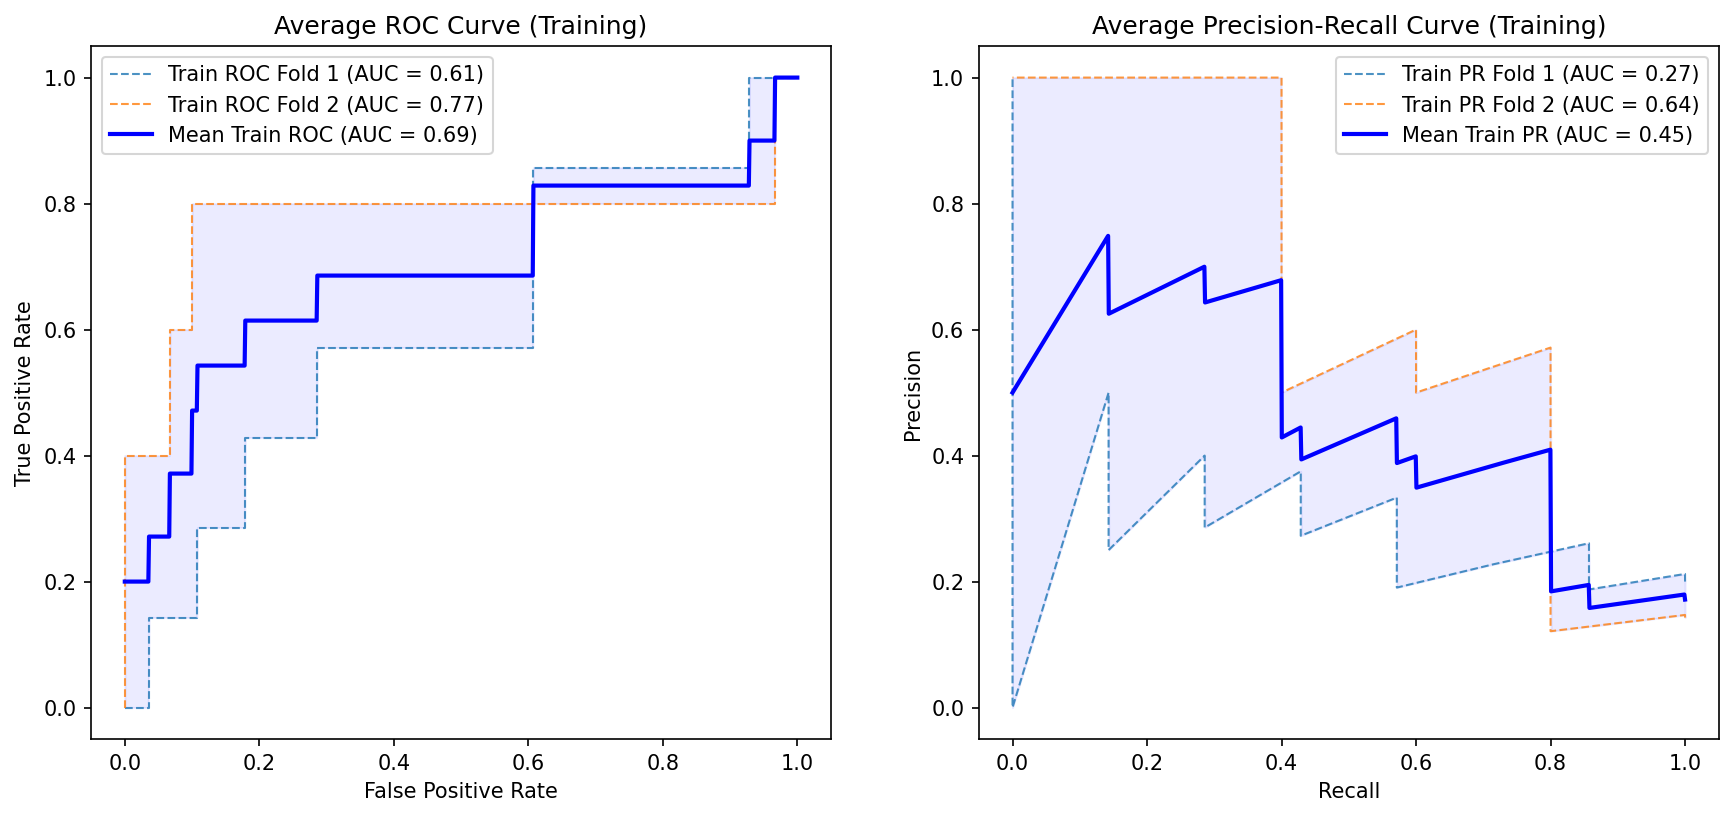

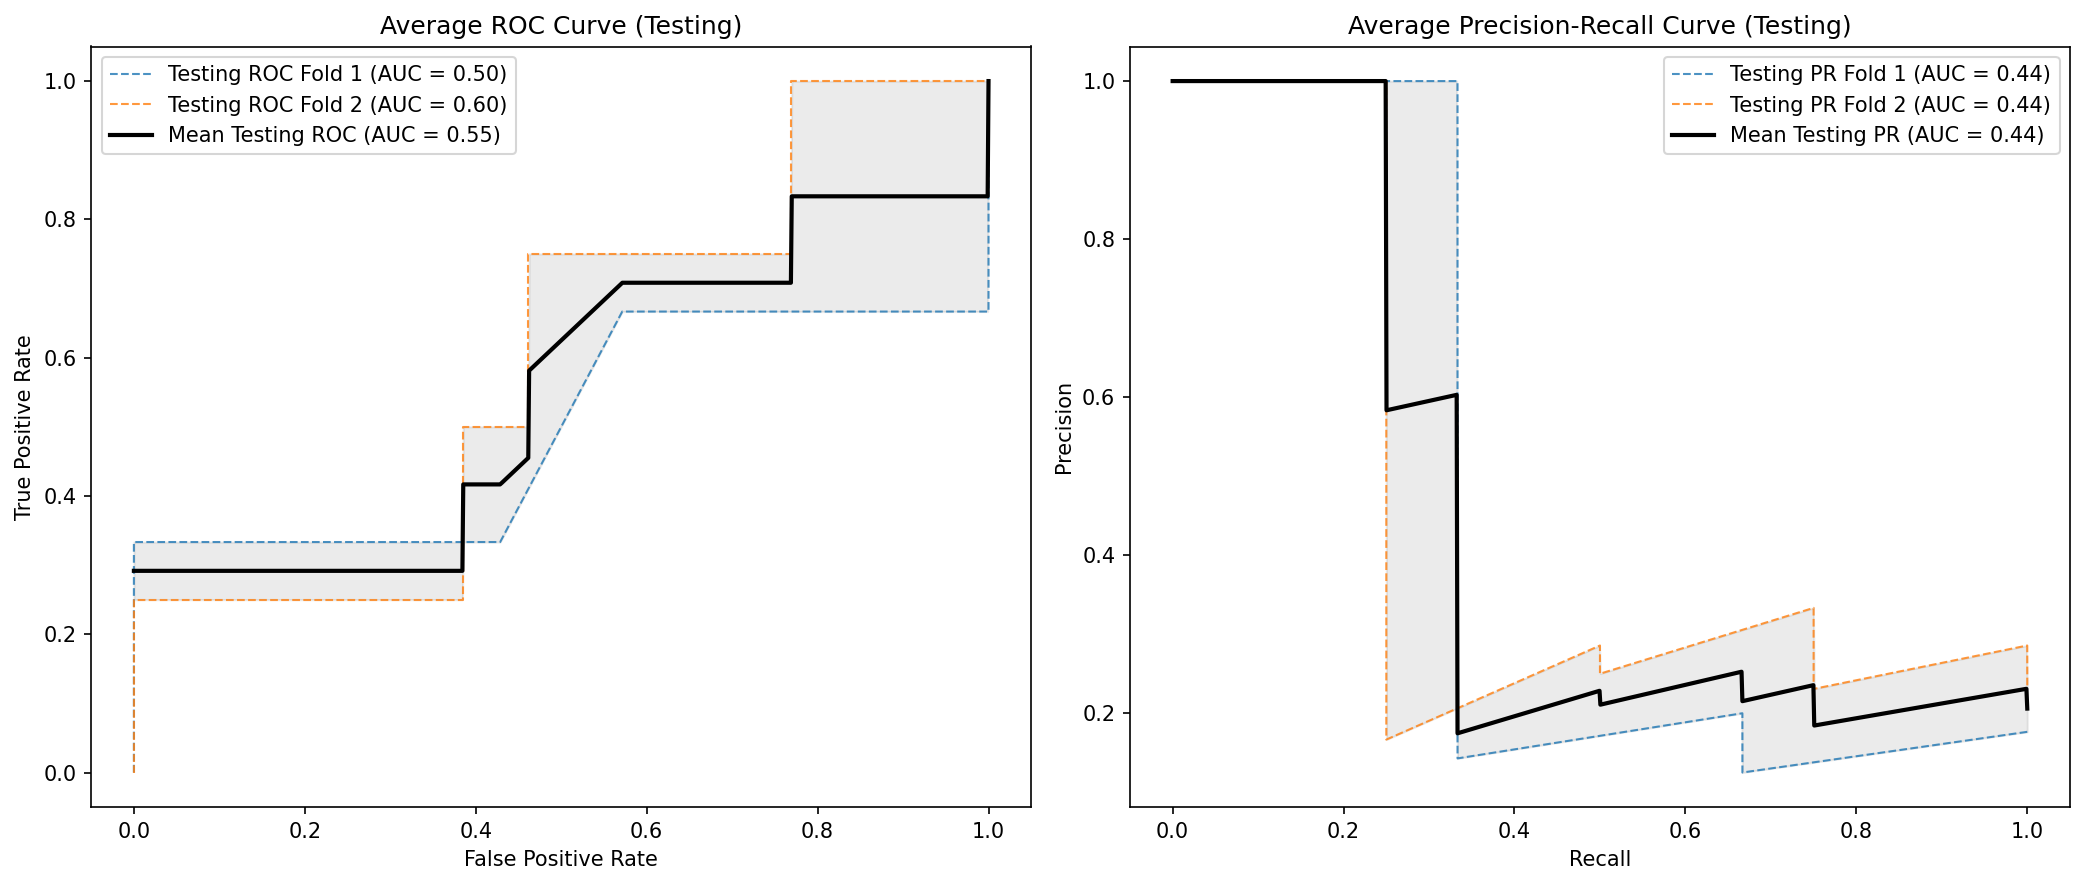

In [13]:
base_path = f"/kaggle/input/b20d-2fold/"
fold_dir = '/kaggle/input/02112024-2fold-splits-cross-validation/split_folds'
b20d = [0.3, 0.8, [0.8]] # 2fold
df_results2 = evaluate_models_(base_path, fold_dir, b20d, k=2)

## 3fold

Hyperparams:= l1_ref: 0.095, dropoutfcc: 0.8, dropoutcnn: 0.8
Evaluating Fold 1...
Evaluating Fold 2...
Evaluating Fold 3...


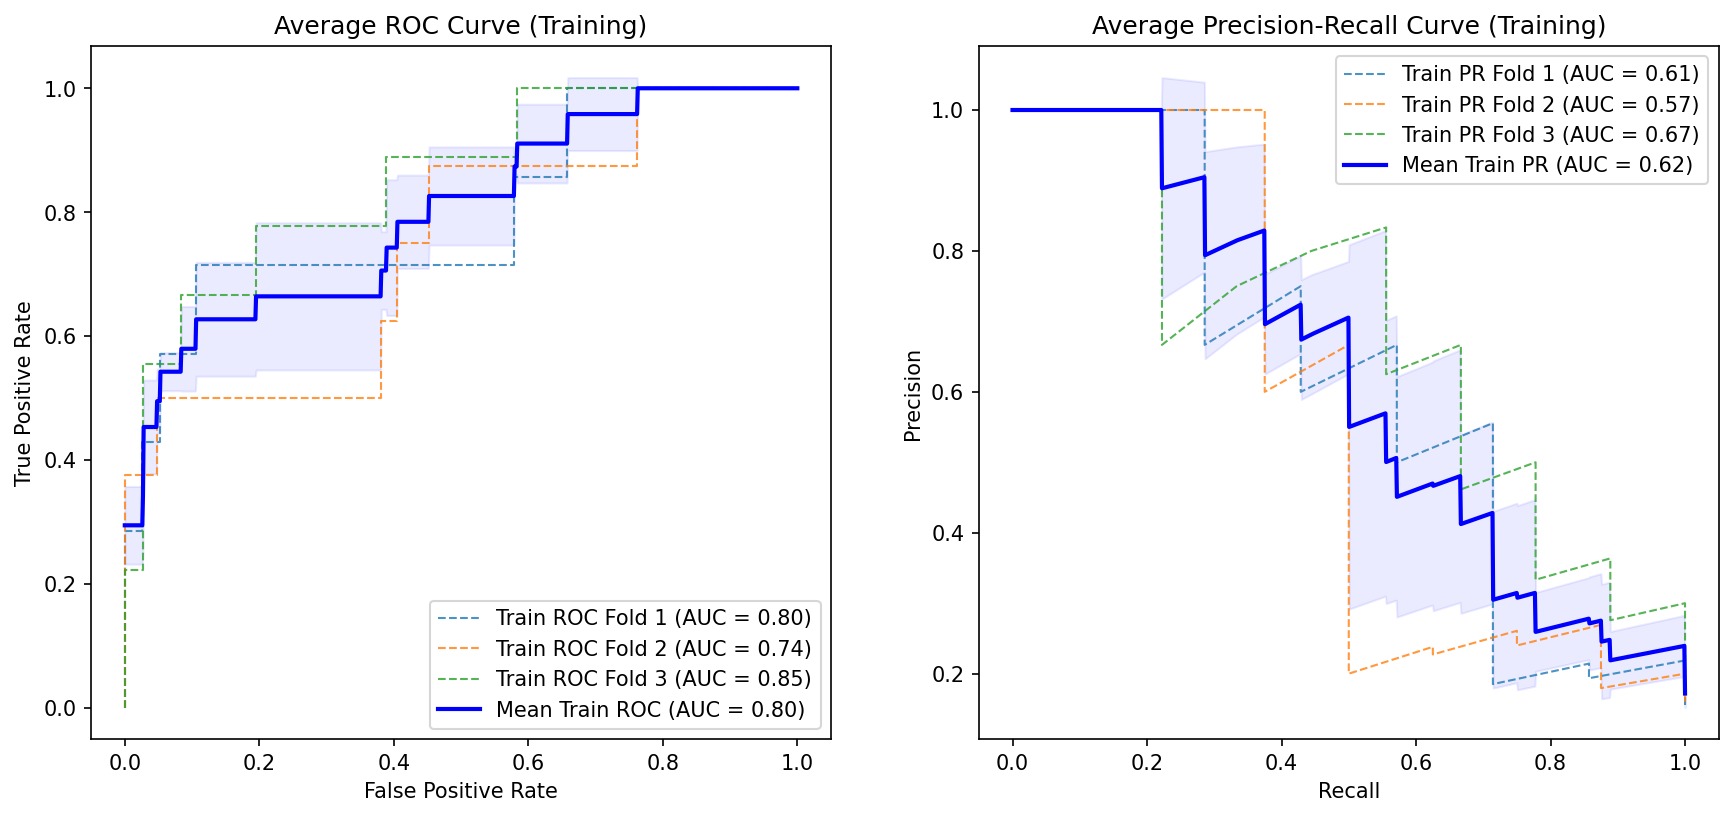

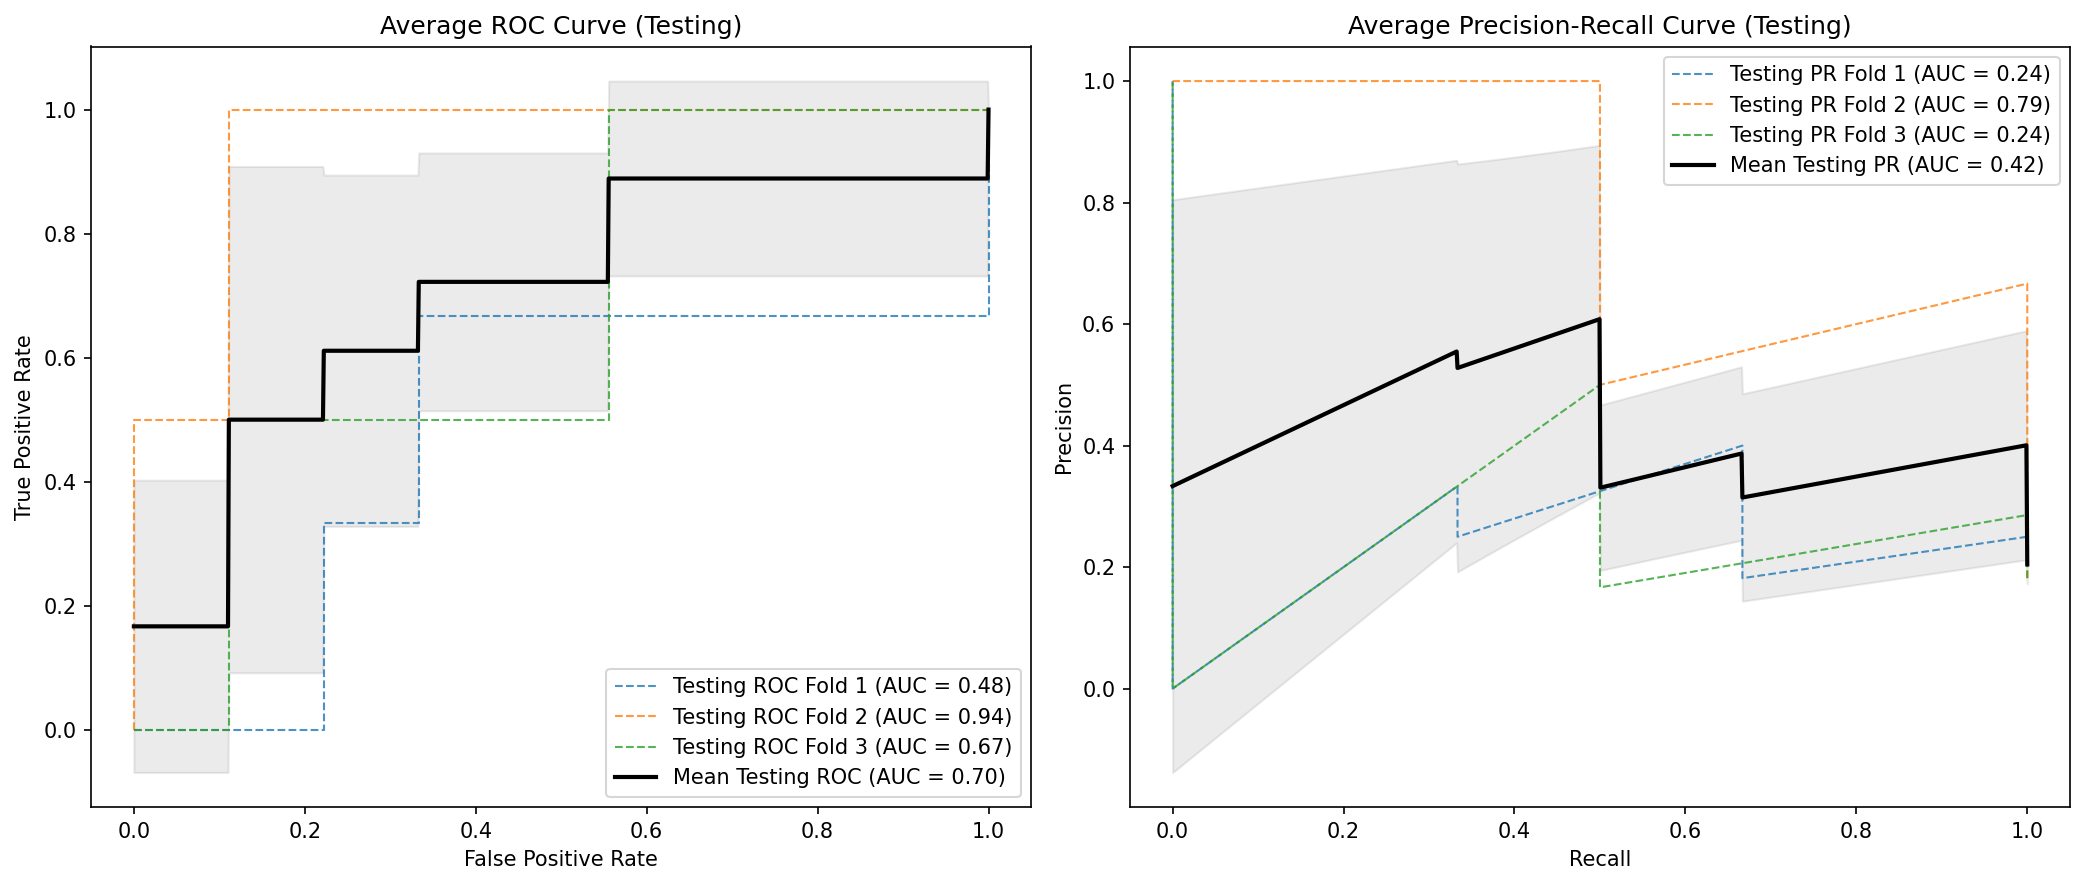

In [14]:
base_path = f"/kaggle/input/b27d-3fold/"
fold_dir = '/kaggle/input/11102024-kfold-3-splits/split_folds'
b27d = [0.095, 0.8, [0.8]] # 3fold
df_results3 = evaluate_models_(base_path, fold_dir, b27d, k=3)

## 5 fold

Hyperparams:= l1_ref: 0.1, dropoutfcc: 0.9, dropoutcnn: 0.9
Evaluating Fold 1...
Evaluating Fold 2...
Evaluating Fold 3...
Evaluating Fold 4...
Evaluating Fold 5...


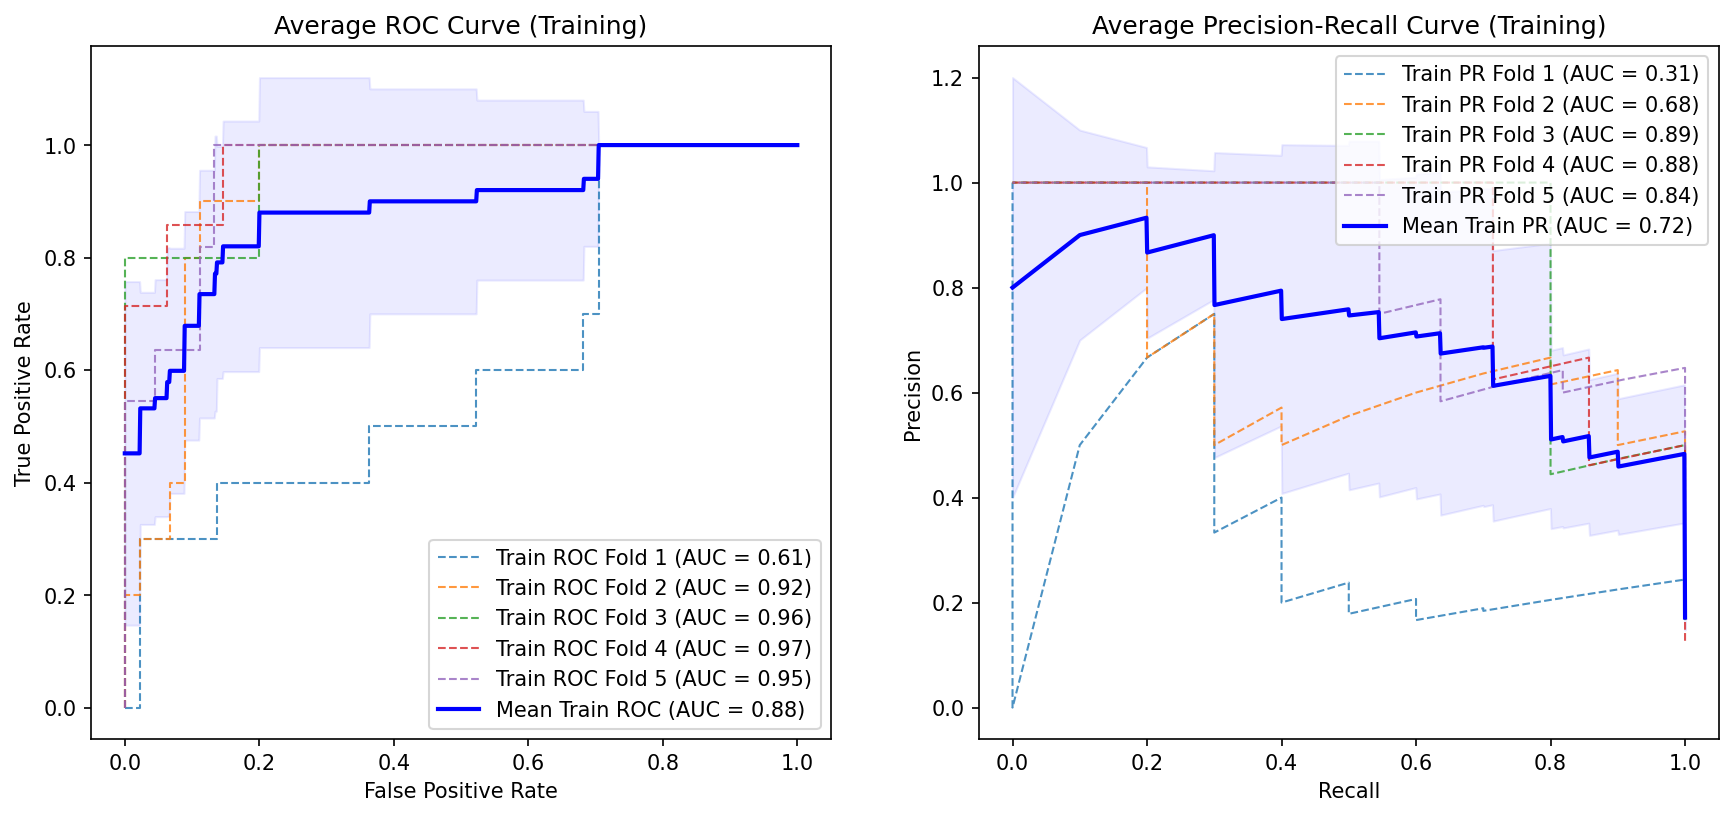

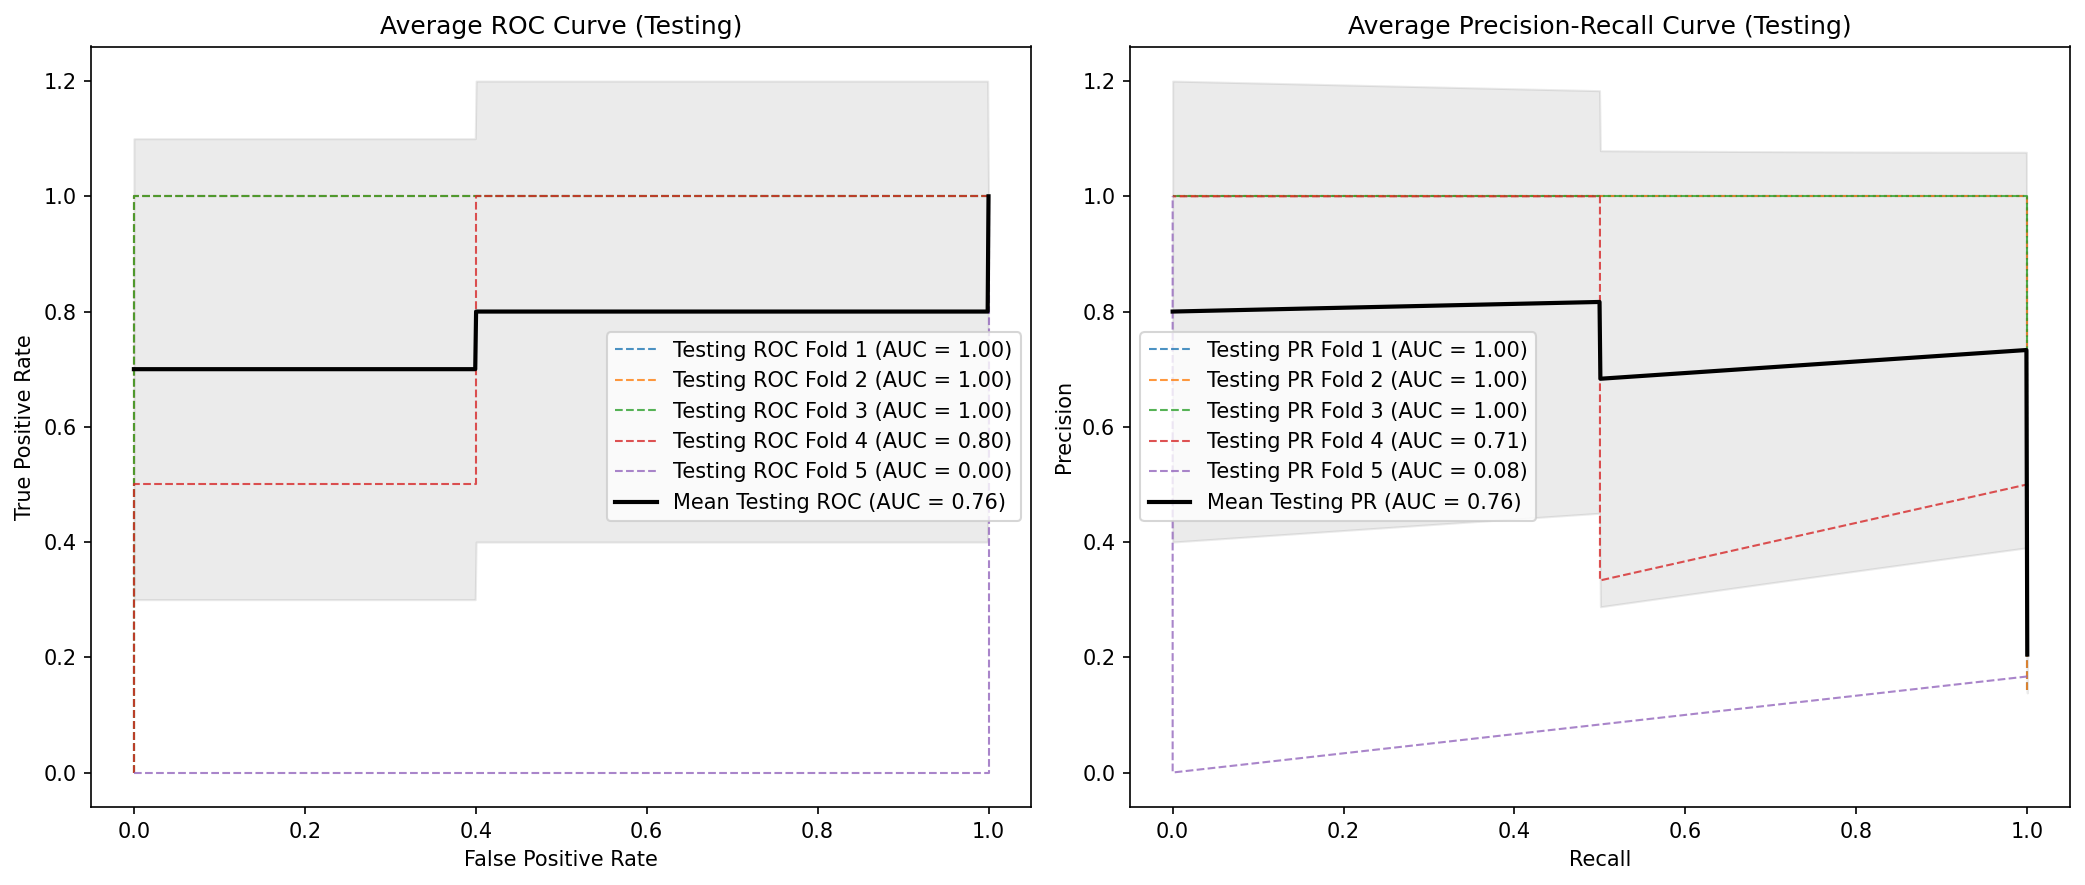

In [15]:
base_path = f"/kaggle/input/b6d-5fold"
fold_dir = '/kaggle/input/13102024-5fold-splits-cross-validation/split_folds'
b6d = [0.1, 0.9, [0.9]] # 5fold
df_results5 = evaluate_models_(base_path, fold_dir, b6d, k=5)